In [1]:
import torch
from torch import nn,Tensor
from d2l import torch as d2l

In [2]:
def nin_block(in_channels,out_channels,kernel_size,strides,padding):
  return nn.Sequential(
    nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),
    nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),
    nn.ReLU()
  )

In [3]:
net = nn.Sequential(
  nin_block(1,96,kernel_size=11,strides=4,padding=0),
  nn.MaxPool2d(3,stride=2),
  nin_block(96,256,kernel_size=5,strides=1,padding=2),
  nn.MaxPool2d(3,stride=2),
  nin_block(256,384,kernel_size=3,strides=1,padding=1),
  nn.MaxPool2d(3,stride=2),
  nn.Dropout(0.5),
  nin_block(384,10,kernel_size=3,strides=1,padding=1),
  # 全局平均池化层 输入高宽等于输入高宽，从每一个通道里面拿出一个类别的预测（最后输出的通道一个，一个通道就代表一类）
  nn.AdaptiveAvgPool2d((1,1)),
  nn.Flatten()
)

In [7]:
X = torch.rand(size=(1,1,224,224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t',X.shape)
  

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.516, train acc 0.812, test acc 0.836
793.2 examples/sec on cuda:0


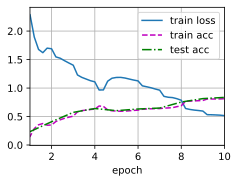

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [11]:
device = torch.device('cuda')
def predict(net,test_iter,n=100):
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X.to(device)).argmax(axis=1))
  titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
  d2l.show_images(X[0:n].reshape((n,224,224)),1,n,titles=titles[0:n])
    

In [14]:
predict(net,test_iter,100)

## 总结
+ NiN块使用卷积层加两个$1\times{1}$卷积层，
  + 后者对每个像素增加了非线性性
+ NiN使用全局平均池化层来替代VGGheAlexNet中的全连接层
  + 不容易过拟合，更少的参数 